In [41]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

In [3]:
data_train = pd.read_csv("Train.csv")
data_test = pd.read_csv("Test.csv")

In [4]:
data_train.head()

,Order ID,Order Date,Country,City,State,Category,Product Name,Quantity,Profit
0,NM-2012-343889,26-04-2015,United States,Lambertfurt,Florida,Furnishings,Table Lamp,3,391.61
1,VA-2022-163003,26-04-2015,United States,West Jennifer,Nevada,Labels,Address Labels,3,579.75
2,KS-2015-985001,26-04-2015,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06
3,WI-2014-993323,27-04-2015,United States,Jensenfurt,Florida,Storage,Vertical Stackable Tray,8,854.52
4,MO-2006-118786,27-04-2015,United States,West Adam,California,Accessories,Inkjet Printer Ink,6,167.34


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22291 entries, 0 to 22290
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      22291 non-null  object 
 1   Order Date    22291 non-null  object 
 2   Country       22291 non-null  object 
 3   City          22291 non-null  object 
 4   State         22291 non-null  object 
 5   Category      22291 non-null  object 
 6   Product Name  22291 non-null  object 
 7   Quantity      22291 non-null  int64  
 8   Profit        22291 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.5+ MB


In [6]:
# Converting the object to timedate delta

data_train['Order Date'] = pd.to_datetime(data_train['Order Date'])

# Extract time components
data_train['Year'] = data_train['Order Date'].dt.year
data_train['Month'] = data_train['Order Date'].dt.month_name()
data_train['MonthNum'] = data_train['Order Date'].dt.month
data_train['DayOfWeek'] = data_train['Order Date'].dt.day_name()

In [7]:
# Dropping the column

data_train.drop('Order Date',axis=1,inplace=True)

In [8]:
data_train.sample(5)

,Order ID,Country,City,State,Category,Product Name,Quantity,Profit,Year,Month,MonthNum,DayOfWeek
3036,NJ-2017-895723,United States,West Mark,Illinois,Copiers,Canon ImageRunner,10,144.54,2016,August,8,Saturday
21234,IL-2016-719647,United States,Lauraville,Idaho,Copiers,Canon ImageRunner,1,-143.93,2024,October,10,Tuesday
8588,MT-2004-960464,United States,Jacobview,New York,Accessories,Inkjet Printer Ink,2,450.53,2019,February,2,Saturday
16523,NM-2006-732833,United States,New James,Texas,Labels,Shipping Labels,3,769.08,2022,August,8,Thursday
10020,AZ-2009-586157,United States,Torresville,Idaho,Labels,Address Labels,4,208.33,2019,October,10,Saturday


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22291 entries, 0 to 22290
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      22291 non-null  object 
 1   Country       22291 non-null  object 
 2   City          22291 non-null  object 
 3   State         22291 non-null  object 
 4   Category      22291 non-null  object 
 5   Product Name  22291 non-null  object 
 6   Quantity      22291 non-null  int64  
 7   Profit        22291 non-null  float64
 8   Year          22291 non-null  int32  
 9   Month         22291 non-null  object 
 10  MonthNum      22291 non-null  int32  
 11  DayOfWeek     22291 non-null  object 
dtypes: float64(1), int32(2), int64(1), object(8)
memory usage: 1.9+ MB


In [10]:
data_train.isna().sum()

,0
Order ID,0
Country,0
City,0
State,0
Category,0
Product Name,0
Quantity,0
Profit,0
Year,0
Month,0


Obs: No null values in data

In [11]:
data_train.duplicated().sum()

np.int64(0)

Obs: No Duplicated values in data

In [12]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,22291.0,5.518101,2.865486,1.00,3.00,6.00,8.00,10.00
Profit,22291.0,398.797705,345.353033,-199.89,99.45,396.44,696.15,999.97
Year,22291.0,2019.764658,2.883372,2015.00,2017.00,2020.00,2022.00,2025.00
MonthNum,22291.0,6.518191,3.450888,1.00,3.00,7.00,10.00,12.00


In [13]:
data_train.describe(include='O').T

,count,unique,top,freq
Order ID,22291,22291,NV-2008-738206,1
Country,22291,1,United States,22291
City,22291,14417,Port Michael,28
State,22291,10,Ohio,2283
Category,22291,5,Storage,4637
Product Name,22291,15,Mobile Pedestal,1586
Month,22291,12,January,1931
DayOfWeek,22291,7,Wednesday,3252


In [14]:
print("Unique values per column")
data_train.nunique().sort_values(ascending = True)

Unique values per column


,0
Country,1
Category,5
DayOfWeek,7
Quantity,10
State,10
Year,11
MonthNum,12
Month,12
Product Name,15
City,14417


In [15]:
for i in data_train.columns:
    print(f"Unique value in {i}")
    print(data_train[i].unique() , '\n')

Unique value in Order ID
['NM-2012-343889' 'VA-2022-163003' 'KS-2015-985001' ... 'LA-2001-826832'
 'GA-2021-314162' 'NV-2008-738206'] 

Unique value in Country
['United States'] 

Unique value in City
['Lambertfurt' 'West Jennifer' 'West Melvinborough' ... 'Victorburgh'
 'Cochranshire' 'Nicholashaven'] 

Unique value in State
['Florida' 'Nevada' 'California' 'Ohio' 'Washington' 'Idaho' 'Georgia'
 'New York' 'Illinois' 'Texas'] 

Unique value in Category
['Furnishings' 'Labels' 'Storage' 'Accessories' 'Copiers'] 

Unique value in Product Name
['Table Lamp' 'Address Labels' 'Vertical Stackable Tray'
 'Inkjet Printer Ink' 'Canon ImageRunner' 'HP LaserJet Pro'
 'Color Coding Labels' 'Shipping Labels' 'Office Chair' 'Standing Desk'
 'Steel Filing Cabinet' 'Xerox 3000' 'Mobile Pedestal' 'Calculator'
 'Stapler'] 

Unique value in Quantity
[ 3  8  6  4  5  7  9  2 10  1] 

Unique value in Profit
[ 391.61  579.75 -118.06 ...  242.42  287.97  102.1 ] 

Unique value in Year
[2015 2016 2017 2018 2

In [16]:
data_less_than_zero = data_train.loc[data_train['Profit'] < 0]
data_less_than_zero

,Order ID,Country,City,State,Category,Product Name,Quantity,Profit,Year,Month,MonthNum,DayOfWeek
2,KS-2015-985001,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06,2015,April,4,Sunday
8,IA-2018-124785,United States,Smithborough,California,Labels,Color Coding Labels,5,-95.11,2015,April,4,Monday
12,KS-2001-255768,United States,Tammymouth,Idaho,Accessories,Inkjet Printer Ink,9,-73.92,2015,April,4,Wednesday
15,NC-2003-260265,United States,Natashaport,New York,Furnishings,Table Lamp,7,-123.77,2015,April,4,Wednesday
18,NJ-2025-907346,United States,Lake Alexis,New York,Copiers,Xerox 3000,4,-149.39,2015,April,4,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
22257,SD-2017-757648,United States,Port Danland,Washington,Copiers,Canon ImageRunner,8,-97.64,2025,March,3,Sunday
22259,MT-2004-701666,United States,South Veronica,Ohio,Labels,Shipping Labels,5,-45.23,2025,March,3,Sunday
22266,DC-2020-298494,United States,Huntside,Texas,Copiers,Xerox 3000,3,-150.04,2025,March,3,Tuesday
22279,SC-2008-342550,United States,Freyfort,Illinois,Furnishings,Standing Desk,10,-62.87,2025,March,3,Thursday


In [17]:
#Numerical Features

numerical_feature = [feature for feature in data_train.columns if data_train[feature].dtype != 'O']
print("No. of Numerical Column: ",len(numerical_feature))
data_train[numerical_feature].head()

No. of Numerical Column:  4


,Quantity,Profit,Year,MonthNum
0,3,391.61,2015,4
1,3,579.75,2015,4
2,3,-118.06,2015,4
3,8,854.52,2015,4
4,6,167.34,2015,4


In [18]:
# Categorical Columns

categorical_feature = [feature for feature in data_train.columns if data_train[feature].dtype == 'O']
print("No. of Categorical Column: ",len(categorical_feature))
data_train[categorical_feature].head()

No. of Categorical Column:  8


,Order ID,Country,City,State,Category,Product Name,Month,DayOfWeek
0,NM-2012-343889,United States,Lambertfurt,Florida,Furnishings,Table Lamp,April,Sunday
1,VA-2022-163003,United States,West Jennifer,Nevada,Labels,Address Labels,April,Sunday
2,KS-2015-985001,United States,West Melvinborough,Florida,Labels,Address Labels,April,Sunday
3,WI-2014-993323,United States,Jensenfurt,Florida,Storage,Vertical Stackable Tray,April,Monday
4,MO-2006-118786,United States,West Adam,California,Accessories,Inkjet Printer Ink,April,Monday


In [19]:
# Correlation Analysis

data_train[numerical_feature].corr()

,Quantity,Profit,Year,MonthNum
Quantity,1.000000,-0.002576,0.007488,0.005977
Profit,-0.002576,1.000000,0.001884,0.011477
Year,0.007488,0.001884,1.000000,-0.117312
MonthNum,0.005977,0.011477,-0.117312,1.000000


Obs - There is no strong correlation among the numerical features, indicating they are largely independent of each other.

In [20]:
# Skewness

data_train[numerical_feature].skew()

,0
Quantity,0.000204
Profit,0.003926
Year,-0.003354
MonthNum,-0.013855


Obs: The distributions of numerical features are approximately symmetric and it not skewed right or left.

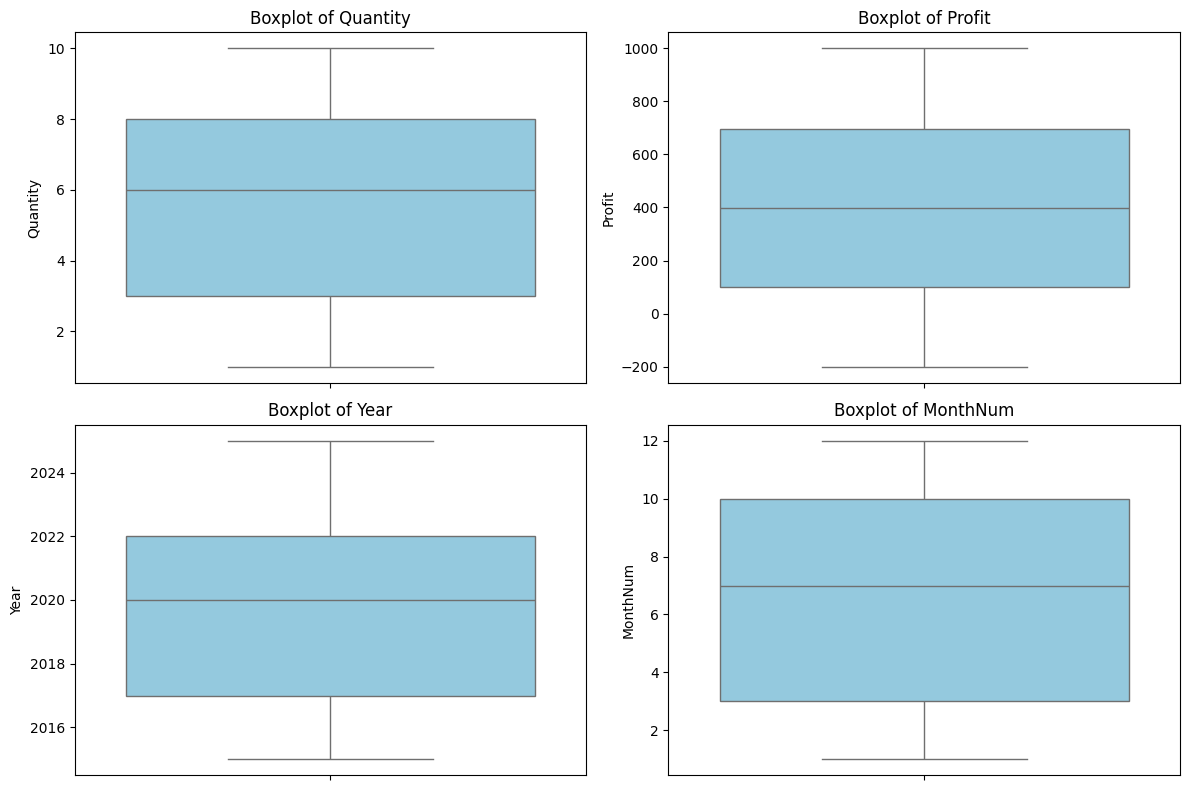

In [21]:
# Outlier Detection

plt.figure(figsize = (12,8))
for i,feature in enumerate(numerical_feature,1):
  plt.subplot(2,2,i)
  sns.boxplot(data=data_train,y=feature,color='skyblue')
  plt.title(f"Boxplot of {feature}")
  plt.tight_layout()
plt.show()

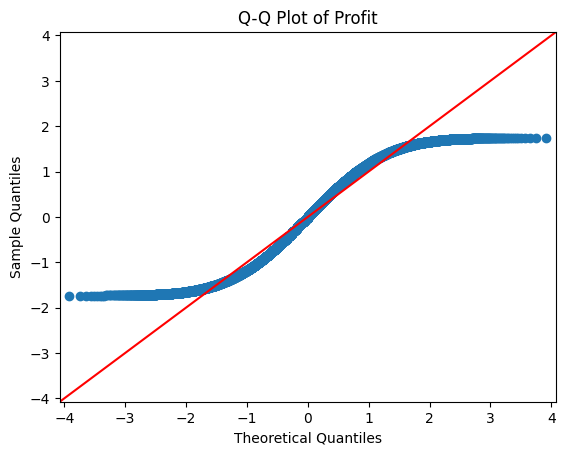

In [22]:
#QQPlot

sm.qqplot(data_train['Profit'], line='45', fit=True)
plt.title("Q-Q Plot of Profit")
plt.show()

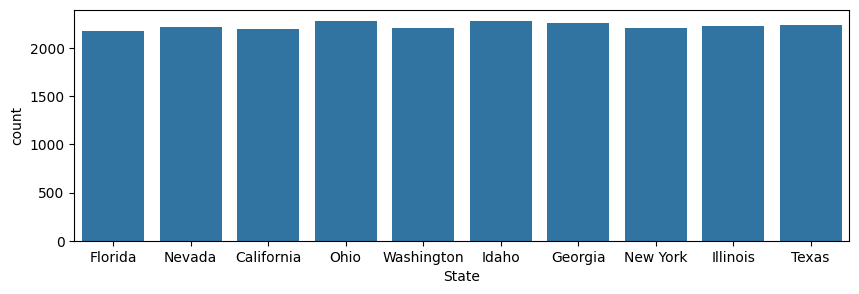

In [23]:
plt.figure(figsize = (10,3))
sns.countplot(data=data_train, x='State')
plt.show()

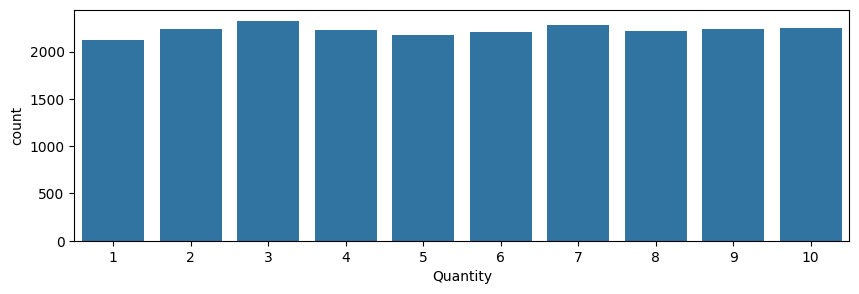

In [24]:
plt.figure(figsize = (10,3))
sns.countplot(data=data_train, x='Quantity')
plt.show()

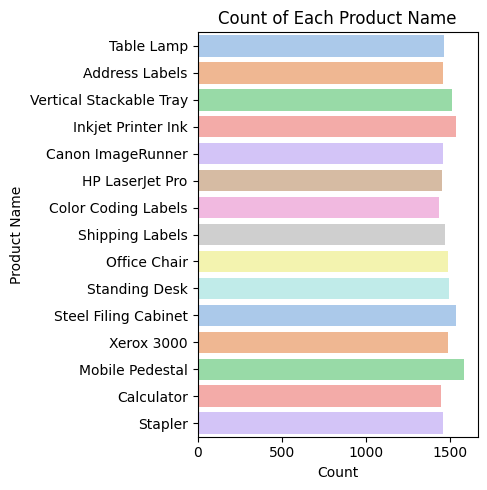

In [25]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data_train, y='Product Name', palette='pastel')
plt.title('Count of Each Product Name')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

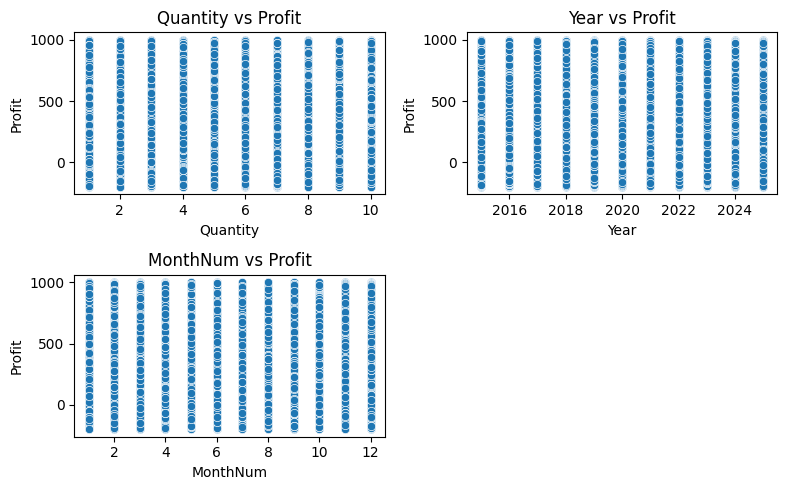

In [26]:
# Scatterplots for numerical features vs Profit
plt.figure(figsize=(8, 5))

plt.subplot(2, 2, 1)
sns.scatterplot(x='Quantity', y='Profit', data=data_train)
plt.title('Quantity vs Profit')

plt.subplot(2, 2, 2)
sns.scatterplot(x='Year', y='Profit', data=data_train)
plt.title('Year vs Profit')

plt.subplot(2, 2, 3)
sns.scatterplot(x='MonthNum', y='Profit', data=data_train)
plt.title('MonthNum vs Profit')

plt.tight_layout()
plt.show()

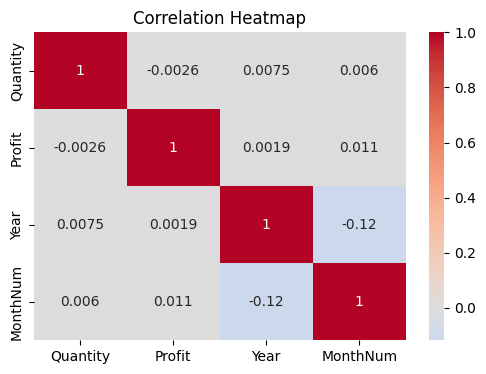

In [27]:
# Heatmap for correlation matrix

plt.figure(figsize=(6, 4))
sns.heatmap(data_train[numerical_feature].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_feature),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_feature)])

In [29]:
# Full pipeline with RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [30]:
X = data_train[data_train[categorical_feature] + data_train[numerical_feature]]
y = data_train['Profit']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17832, 12)
(4459, 12)
(17832,)
(4459,)


In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Quantity', 'Profit', 'Year',
                                                   'MonthNum']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Order ID', 'Country',
                                                   'City', 'State', 'Category',
                                                   'Product Name', 'Month',
                                                   'DayOfWeek'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [33]:
y_pred = pipeline.predict(X_test)

In [37]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(y_test, y_pred):
  """
  Calculates the Root Mean Squared Error (RMSE) using scikit-learn's mean_squared_error.

  Args:
    y_true: 1D array-like of true values.
    y_pred: 1D array-like of predicted values.

  Returns:
    float: The Root Mean Squared Error.
  """
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  return rmse

In [38]:
rmse_value = calculate_rmse(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse_value:.2f}')

Root Mean Squared Error: 348.32


In [44]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        random_state=42,
        eval_metric='rmse'
    ))
])

In [50]:
xgb_pipeline.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True
)

ValueError: Pipeline.fit does not accept the eval_set parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer  # For handling missing values

# Load data
data_train = pd.read_csv("Train.csv")
data_test = pd.read_csv("Test.csv")

# Feature Engineering
def feature_engineer(df):
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Year'] = df['Order Date'].dt.year
    df['Month'] = df['Order Date'].dt.month_name()
    df['MonthNum'] = df['Order Date'].dt.month
    df['DayOfWeek'] = df['Order Date'].dt.day_name()
    df.drop('Order Date', axis=1, inplace=True)
    return df

data_train = feature_engineer(data_train.copy())
data_test = feature_engineer(data_test.copy())  # Apply to test data too!

# Preprocessing
numerical_features = ['Quantity', 'Year', 'MonthNum']
categorical_features = ['Country', 'State', 'Category', 'Product Name', 'Month', 'DayOfWeek']

# Create transformers - handling missing values
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill NaN with mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Fill NaN with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model Training and Evaluation
def train_and_evaluate(model, param_grid, X_train, y_train, X_val, y_val, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)  # Use neg_rmse
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred_val = best_model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)

    print(f"Best Hyperparameters for {model_name}: {grid_search.best_params_}")
    print(f"Validation Set - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R-squared: {r2:.2f}")

    return best_model, {'rmse': rmse, 'mae': mae, 'r2': r2}

# Prepare data for modeling
X = data_train.drop(['Order ID', 'Profit'], axis=1) #  Order ID is dropped here
y = data_train['Profit']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.copy()
X_val = X_val.copy()

#models
models = {
    "LinearRegression": (LinearRegression(), {}),
    "DecisionTreeRegressor": (DecisionTreeRegressor(random_state=42), {'model__max_depth': [5, 10, 15], 'model__min_samples_split': [10, 50, 100]}),  # Changed here
    "RandomForestRegressor": (RandomForestRegressor(random_state=42), {'model__n_estimators': [50, 100], 'model__max_depth': [10, 20], 'model__min_samples_split': [10, 50]}), # Changed here
    "GradientBoostingRegressor": (GradientBoostingRegressor(random_state=42), {'model__n_estimators': [50, 100], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [5, 10]}), # Changed here
    "XGBoostRegressor": (xgb.XGBRegressor(objective='reg:squarederror', random_state=42), {'model__n_estimators': [50, 100], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 6]}) # Changed here
    # "SVR": (SVR(), {'model__C': [1, 10], 'model__kernel': ['linear', 'rbf']}) # SVR can be very slow
}

best_models = {}
model_results = {}

# Iterate through models, train, and evaluate
for name, (model, param_grid) in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    best_model, metrics = train_and_evaluate(pipeline, param_grid, X_train, y_train, X_val, y_val, name)
    best_models[name] = best_model
    model_results[name] = metrics

#  ---  Final Model Selection ---
best_model_name = min(model_results, key=lambda k: model_results[k]['rmse'])  # Model with lowest RMSE
final_model = best_models[best_model_name]

print(f"\n--- Final Model Selected: {best_model_name} ---\n")

# Prepare test data (CRUCIAL:  same preprocessing as training)
X_test = data_test.drop("Order ID", axis=1)  # Drop Order ID
y_test_true = None #  If you have true y_test values, load them here for final evaluation

X_test = X_test.copy()  # To avoid potential modification warnings

# Make predictions on the test set
y_test_pred = final_model.predict(X_test)

# Evaluate on the test set (if you have true labels)
if y_test_true is not None:
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    test_r2 = r2_score(y_test_true, y_test_pred)
    print("\n--- Test Set Evaluation ---")
    print(f"Test Set - RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R-squared: {test_r2:.2f}")

# Create submission file (adapt as needed)
submission = pd.DataFrame({'Order ID': data_test['Order ID'], 'Profit': y_test_pred})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


<ipython-input-2-59c1d7023661>:23: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Order Date'] = pd.to_datetime(df['Order Date'])
<ipython-input-2-59c1d7023661>:23: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Order Date'] = pd.to_datetime(df['Order Date'])


Best Hyperparameters for LinearRegression: {}
Validation Set - RMSE: 349.14, MAE: 304.08, R-squared: -0.01
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters for DecisionTreeRegressor: {'model__max_depth': 5, 'model__min_samples_split': 100}
Validation Set - RMSE: 349.61, MAE: 304.33, R-squared: -0.01
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters for RandomForestRegressor: {'model__max_depth': 10, 'model__min_samples_split': 50, 'model__n_estimators': 100}
Validation Set - RMSE: 349.74, MAE: 304.57, R-squared: -0.01
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters for GradientBoostingRegressor: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 50}
Validation Set - RMSE: 348.50, MAE: 303.66, R-squared: -0.00
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters for XGBoostRegressor: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'm